In [57]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from pypfopt import (
    BlackLittermanModel,
    EfficientFrontier,
    black_litterman,
    expected_returns,
    plotting,
    risk_models,
)

In [58]:
ano = 2024 # Ano para o qual serão gerados os pesos

data_final = datetime(ano-1,12,31) # Data no formato AAAA-MM-DD
data_incial = datetime(ano -5 , 1, 1)

print('Dados rodados entre ' + str(data_incial) + ' e ' + str(data_final))
geografia = ['BR', 'US']
i = 0 # É o índice que vai definir se vai rodar para BR i = 0 ou US i = 1

sheets = pd.ExcelFile("Matriz Base.xlsx").sheet_names
# sheets

Dados rodados entre 2019-01-01 00:00:00 e 2023-12-31 00:00:00


In [59]:
dados = pd.read_excel("Matriz Base.xlsx",sheet_name= 'Dados ' + str(geografia[i]), index_col=0)
indices = dados.columns
dados = dados.loc[(dados.index>=data_incial) & (dados.index <= data_final)]
dados

returns = dados.pct_change().dropna()
retornos_indices = expected_returns.mean_historical_return(dados)
matriz_cov_indices = risk_models.sample_cov(dados)

In [60]:
# # Now try with a nonconvex objective from  Kolm et al (2014)
# def deviation_risk_parity(w, cov_matrix):
#     diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
#     return (diff**2).sum().sum()


In [61]:
# Black-Litterman
bench = pd.read_excel("Dados Indices_2013-2023.xlsx",sheet_name='Bench',index_col=0)
bench['Carteira 50 -50'] = 0.5*bench['LEGATRUU Index'] + 0.5*bench['MXWD Index']
bench = bench.loc[(bench.index >= data_incial) & (bench.index<=data_final)]
# display(bench)

delta = black_litterman.market_implied_risk_aversion(bench['Carteira 50 -50'])

market_cap = pd.read_excel('Matriz Base.xlsx',sheet_name= 'Market Cap '+ str(geografia[i]),index_col=0)
market_cap.columns = indices
market_cap_ano = market_cap.loc[market_cap.index.year == (ano -1)]
market_cap_ano = market_cap_ano.to_dict(orient= 'records')[0]


prior = black_litterman.market_implied_prior_returns(market_cap_ano, delta, matriz_cov_indices)

# prior

In [62]:
visoes_absolutas = pd.read_excel("Matriz Base.xlsx", sheet_name= 'Visoes Absolutas '+str(geografia[i]),index_col=0)
visoes_absolutas = visoes_absolutas.loc[visoes_absolutas.index == ano].T.sort_values(by = ano, ascending = False)

In [63]:
visoes_relativas = pd.read_excel("Matriz Base.xlsx",sheet_name= 'Visoes Relativas '+str(geografia[i]),index_col=0)

visoes_relativas = visoes_relativas.loc[visoes_relativas.index == ano].T.sort_values(by = ano)

In [64]:
visoes_absolutas

,2024
S&P Small Cap 600,0.098523
S&P 500,0.054065
U.S Universal,0.025570
Global Agg. Ex-USA,0.020863
World ex-USA,0.019317
Emerging Markets,0.009715


In [65]:
display(visoes_absolutas.tail(2))

display(visoes_relativas.tail(6))

,2024
World ex-USA,0.019317
Emerging Markets,0.009715


,2024
S&P 500_sub_Emerging Markets,0.044350
S&P Small Cap 600_sub_S&P 500,0.044458
S&P Small Cap 600_sub_U.S Universal,0.072953
S&P Small Cap 600_sub_Global Agg. Ex-USA,0.077660
S&P Small Cap 600_sub_World ex-USA,0.079207
S&P Small Cap 600_sub_Emerging Markets,0.088808


In [66]:
##################################################################################################################################
############################################          Posicoes dos Indices    ####################################################
############################################  1 - US Universal                ####################################################
############################################  2 - S&P 500                     ####################################################
############################################  3 - World ex-USA                ####################################################
############################################  4 - Emerging Markets            ####################################################
############################################  5 - Global Agg ex-USA           ####################################################
############################################  6 - S&P 600                     ####################################################
##################################################################################################################################

##################################################################################################################################
# 1. Visão Absoluta: World ex_USA vai subir 10% (variável views primeira posição 0.1)
# 2. Visão Relativa: S&P 600 vai performar melhor que o Global Agg em 4% (variável views segunda posição 0.04)
# 3. Variável picking tem as 6 posições dos indices, primeira linha Visoes Absolutas valor 1 na posição para qual tem a visão
#    segunda linha Visoes Relativas com valor 1 para o indice de melhor performance e -1 para pior performance
##################################################################################################################################
views = np.array([0.0948 , 0.0335]).reshape(-1, 1)
picking = np.array(
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, -1, 1, 0],
        
    ]
)

In [89]:
bl = BlackLittermanModel(matriz_cov_indices, Q=views, P=picking, pi=prior, tau=0.01)
rets = bl.bl_returns()
cov = bl.bl_cov()
ef = EfficientFrontier(rets, cov)
ef.add_constraint(lambda x: x[3] <=0.17) # Restrição para limitar Emerging Markets em 17%
ef.add_constraint(lambda x: x[4] <=0.15) # Restrição para limitar Global Agg em 15%
# ef.add_constraint (lambda x : x <= 0.4)  # Restrição para limitar concentração máxima em qualquer ativo em 40%
# ef.add_constraint (lambda x : x >= 0.05)  # Restrição para limitar concentração mínima em qualquer ativo em 5%
# ef.efficient_risk(0.17) # Restrição para otimizar a carteira pra volatilidade alvo
ef.min_volatility() # Restrição para otimizar a carteira pra mínima volatilidade 
# ef.max_sharpe(risk_free_rate= -0.10 ) # Restrição para otimizar a carteira pra máximo sharpe

print(ef.clean_weights())
ef.portfolio_performance(verbose=True)

OrderedDict([('U.S Universal', 0.44522), ('S&P 500', 0.0), ('World ex-USA', 0.18249), ('Emerging Markets', 0.17), ('Global Agg. Ex-USA', 0.15), ('S&P Small Cap 600', 0.05229)])
Expected annual return: 9.0%
Annual volatility: 13.8%
Sharpe Ratio: 0.50


(0.0895189345366711, 0.13845166393587308, 0.5021170028615208)

In [91]:
ef.portfolio_performance(points)

Expected annual return: 9.0%
Annual volatility: 13.8%
Sharpe Ratio: 0.50


(0.0895189345366711, 0.13845166393587308, 0.5021170028615208)

In [68]:
pd.DataFrame(list(ef.clean_weights().items()),columns=['Asset Class','Weight']).T

,0,1,2,3,4,5
Asset Class,U.S Universal,S&P 500,World ex-USA,Emerging Markets,Global Agg. Ex-USA,S&P Small Cap 600
Weight,0.44686,0.0,0.18069,0.17,0.15,0.05245


<Axes: xlabel='Volatility', ylabel='Return'>

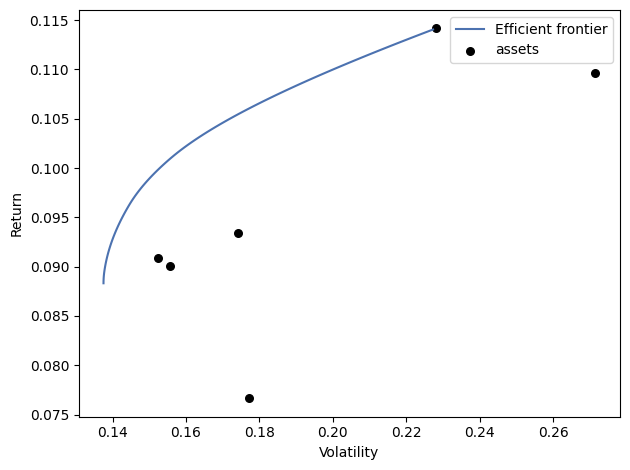

In [97]:
ef2 = EfficientFrontier(rets, matriz_cov_indices)
plotting.plot_efficient_frontier(ef2)


In [104]:
 np.linspace(rets.min(), rets.max(), points)

array([0.0766547 , 0.07703352, 0.07741233, 0.07779115, 0.07816997,
       0.07854879, 0.07892761, 0.07930643, 0.07968524, 0.08006406,
       0.08044288, 0.0808217 , 0.08120052, 0.08157934, 0.08195815,
       0.08233697, 0.08271579, 0.08309461, 0.08347343, 0.08385225,
       0.08423106, 0.08460988, 0.0849887 , 0.08536752, 0.08574634,
       0.08612516, 0.08650397, 0.08688279, 0.08726161, 0.08764043,
       0.08801925, 0.08839807, 0.08877688, 0.0891557 , 0.08953452,
       0.08991334, 0.09029216, 0.09067098, 0.09104979, 0.09142861,
       0.09180743, 0.09218625, 0.09256507, 0.09294389, 0.0933227 ,
       0.09370152, 0.09408034, 0.09445916, 0.09483798, 0.0952168 ,
       0.09559561, 0.09597443, 0.09635325, 0.09673207, 0.09711089,
       0.09748971, 0.09786852, 0.09824734, 0.09862616, 0.09900498,
       0.0993838 , 0.09976262, 0.10014143, 0.10052025, 0.10089907,
       0.10127789, 0.10165671, 0.10203553, 0.10241434, 0.10279316,
       0.10317198, 0.1035508 , 0.10392962, 0.10430844, 0.10468

In [107]:
ef2.efficient_return(0.114)
ef2.portfolio_performance()

(0.11399811878657994, 0.22686566421806584, 0.4143338266306702)

In [110]:

# Definir o número de pontos na fronteira eficiente
points = 100
target_returns = np.linspace(rets.min()*1.001, rets.max()*0.999, points)
risks = []
returns = []

# Calcular a fronteira eficiente
for target_return in target_returns:
    # print(target_return)
    ef2.efficient_return(target_return)
    ret, risk, _ = ef2.portfolio_performance()
    risks.append(risk)
    returns.append(ret)

# Convertendo a fronteira eficiente em DataFrame
ef_df = pd.DataFrame({"Return": returns, "Risk": risks})


In [113]:
ef_df.to_excel("Froteira Eficiente 2024.xlsx")